1. Settings

In [1]:
import torch

print(torch.__version__)

1.10.1+cu102


In [2]:
!python --version

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Python 3.8.10


In [3]:
!pip install gluonnlp==0.8.0 pandas tqdm
!pip install mxnet
!pip install sentencepiece
!pip install openpyxl
!pip install numpy==1.21.0
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision mast

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, tqdm_notebook
import gluonnlp as nlp
import numpy as np
import pandas as pd
import random

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#KoBERT
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
#transformer
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

/usr/local/lib/python3.8/dist-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


In [5]:
#GPU 설정
device = torch.device("cuda:0")

import os

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla P100-SXM2-16GB


In [6]:
#bertmodel, vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /root/kobert/.cache/kobert_v1.zip
using cached model. /root/kobert/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


2. Load Dataset

(1) preprocessing

In [7]:
def preparing_data_1(df:pd.DataFrame) -> pd.DataFrame:
    # SettingWithCopyWarning
    data = df.copy()

    def func(c):
        if c == "sad" : return "sadness"
        elif c == "anger" : return "angry"
        else : return c
        
    data = data[["발화문", "상황"]]
    data.columns = ["sentence", "class"]
    data.reset_index(drop=True, inplace=True)
    data["class"] = data["class"].apply(func)
        
    return data

In [8]:
def preparing_data_2(df:pd.DataFrame) -> pd.DataFrame:
    # SettingWithCopyWarning
    data = df.copy()
    
    def func(c):
        if c == "분노" : return "angry"
        elif c == "혐오" : return "disgust"
        elif c == "중립" : return "neutral"
        elif c == "놀람" : return "surprise"
        elif c == "행복" : return "happiness"
        elif c == "공포" : return "fear"
        elif c == "슬픔" : return "sadness"
        else : return np.nan

    # cleaning data    
    data = data[["Unnamed: 1" ,"Unnamed: 2"]]
    data.columns = ["sentence", "class"]
    data.reset_index(drop=True, inplace=True)
    data["class"] = data["class"].apply(func)
    data.dropna(inplace=True)

    # imbalanced data 
    """
    
    # all data size
    data.shape >= 50000

    # one column data size
    data["neutral"].shape >= 40000
    
    # apply random undersampling
    data["neutral"].shape : 10000

    """
    neutral_index = list(data[data["class"] == "neutral"].index)
    remove_index = random.sample(neutral_index,33786)
    data.drop(remove_index, inplace=True)
    
    return data

In [9]:
#
train1 = preparing_data_1(pd.read_csv('/root/kobert/dataset/year_4.csv', index_col=0, encoding="cp949"))
train2 = preparing_data_1(pd.read_csv('/root/kobert/dataset/year_5_1.csv', index_col=0, encoding="cp949"))
train3 = preparing_data_1(pd.read_csv('/root/kobert/dataset/year_5_2.csv', index_col=0, encoding="cp949"))

#
train4 = preparing_data_2(pd.read_excel('/root/kobert/dataset/chat_korean.xlsx', index_col=0))

# concat
train = pd.DataFrame()
train = pd.concat([train, train1], axis=0, ignore_index=True)
train = pd.concat([train, train2], axis=0, ignore_index=True)
train = pd.concat([train, train3], axis=0, ignore_index=True)
train = pd.concat([train, train4], axis=0, ignore_index=True)

In [10]:
from collections import Counter
Counter(train['class'])

Counter({'angry': 15263,
         'sadness': 15972,
         'fear': 4229,
         'disgust': 4880,
         'neutral': 13262,
         'happiness': 5578,
         'surprise': 6621})

(2) label encoding

In [11]:
train.loc[(train['class'] == "sadness"), 'class'] = 0 
train.loc[(train['class'] == "fear"), 'class'] = 1  
train.loc[(train['class'] == "disgust"), 'class'] = 2  
train.loc[(train['class'] == "neutral"), 'class'] = 3  
train.loc[(train['class'] == "happiness"), 'class'] = 4  
train.loc[(train['class'] == "angry"), 'class'] = 5  
train.loc[(train['class'] == "surprise"), 'class'] = 6  

data_list = []
for sen, label in zip(train['sentence'], train['class'])  :
    data = []   
    data.append(sen)
    data.append(str(label))

    data_list.append(data)

label_decoder = {0: "sadness", 1: "fear", 2: "disgust", 3: "neutral", 4: "happiness", 5: "angry", 6: "surprise"}

(3) split data train /valid /test

In [12]:
from sklearn.model_selection import train_test_split

# Extract labels for stratification
labels = [item[1] for item in data_list]

train_temp, test = train_test_split(data_list, test_size=0.2,random_state=1234, stratify=labels)
train, valid = train_test_split(train_temp, test_size=0.25, random_state=1234)  # 0.25 x 0.8 = 0.2

(4) tokenizing

In [13]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /root/kobert/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [14]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

(5) Setting parameters

In [15]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [16]:
# prepare dataloaders
data_train = BERTDataset(train, 0, 1, tok, max_len, True, False)
data_valid = BERTDataset(valid, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tok, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [17]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

3. Model Training

(1) load model

In [18]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

(2) training

epoch 1 train acc 0.5852595424827625
epoch 1 valid acc 0.771556062041203
Model saved at epoch 1, valid acc 0.771556062041203
epoch 2 train acc 0.8055101056231629
epoch 2 valid acc 0.7930307246033625
Model saved at epoch 2, valid acc 0.7930307246033625
epoch 3 train acc 0.861020640469192
epoch 3 valid acc 0.7968897999052806
Model saved at epoch 3, valid acc 0.7968897999052806
epoch 4 train acc 0.901577479878032
epoch 4 valid acc 0.8059251420790907
Model saved at epoch 4, valid acc 0.8059251420790907
epoch 5 train acc 0.9294868383100293
epoch 5 valid acc 0.8012224721761781


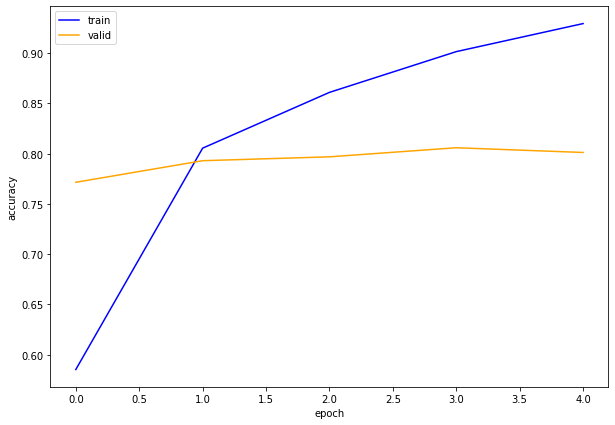

              precision    recall  f1-score   support

     sadness       0.89      0.85      0.87      3194
        fear       0.86      0.89      0.88       846
     disgust       0.87      0.86      0.86       976
     neutral       0.70      0.75      0.72      2652
   happiness       0.86      0.82      0.84      1116
       angry       0.85      0.84      0.85      3053
    surprise       0.70      0.72      0.71      1324

    accuracy                           0.81     13161
   macro avg       0.82      0.82      0.82     13161
weighted avg       0.82      0.81      0.82     13161

Test accuracy: 0.8142238431730112


In [19]:
# initialize best validation accuracy and corresponding epoch number
best_val_acc = 0.0
best_epoch = 0

train_acc_list = []
valid_acc_list = []

for e in range(num_epochs):
    train_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        train_acc += calc_accuracy(out, label)
    train_acc_list.append(train_acc / (batch_id+1))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    model.eval()
    valid_acc = 0.0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(valid_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        valid_acc += calc_accuracy(out, label)
    valid_acc /= (batch_id+1)
    valid_acc_list.append(valid_acc)
    print("epoch {} valid acc {}".format(e+1, valid_acc))

    # save model if validation accuracy has increased
    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        best_epoch = e
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"Model saved at epoch {best_epoch+1}, valid acc {best_val_acc}")

# load best model
model.load_state_dict(torch.load('best_model.pt'))

# plot accuracy graph
plt.figure(figsize=(10, 7))
plt.plot(train_acc_list, color='blue', label='train')
plt.plot(valid_acc_list, color='orange', label='valid')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# calculate f1 score, precision, recall and accuracy
model.eval()
y_true = []
y_pred = []
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    label = label.long().to(device)
    out = model(token_ids, valid_length, segment_ids)
    max_vals, max_indices = torch.max(out, 1)
    y_true += list(label.cpu().numpy())
    y_pred += list(max_indices.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=label_decoder.values()))
print("Test accuracy: {}".format(accuracy_score(y_true, y_pred)))

(3) save the trained model

In [20]:
# PATH = '/root/kobert/' 
# torch.save(model, PATH + 'KoBERT_ver1.pt')  # 전체 모델 저장
# torch.save(model.state_dict(), PATH + 'KoBERT_ver1_state_dict.pt')  # 모델 객체의 state_dict 저장
# torch.save({
#     'model': model.state_dict(),
#     'optimizer': optimizer.state_dict()
# }, PATH + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

(4) save the requirements

In [21]:
pip freeze > requirements.txt

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Note: you may need to restart the kernel to use updated packages.


3. Model Testing

In [22]:
# function to preprocess input sentence
def preprocess_sentence(sentence):
    transform = nlp.data.BERTSentenceTransform(tok, max_len, pad=True, pair=False)
    return transform([sentence])

# function to predict class of input sentence
def predict_sentence(sentence):
    token_ids, valid_length, segment_ids = preprocess_sentence(sentence)
    token_ids = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)
    valid_length = torch.tensor(valid_length, dtype=torch.long).unsqueeze(0).to(device)
    segment_ids = torch.tensor(segment_ids, dtype=torch.long).unsqueeze(0).to(device)
    out = model(token_ids, valid_length, segment_ids)
    max_vals, max_indices = torch.max(out, 1)
    return max_indices.cpu().numpy()[0]

while True:
    # get sentence from user
    sentence = input("Enter a sentence to classify (or 'quit' to stop): ")
    if sentence.lower() == 'quit':
        break

    # predict class of input sentence
    prediction = predict_sentence(sentence)

    print("Predicted class: {}".format(label_decoder[prediction]))


Enter a sentence to classify (or 'quit' to stop):  너 덕분에 할수 있었어 고맙다ㅠㅠㅠ


Predicted class: happiness


Enter a sentence to classify (or 'quit' to stop):  엥 진짜로 ?? 심각한데..;


Predicted class: surprise


Enter a sentence to classify (or 'quit' to stop):  왜 자꾸 하지 말란 짓을 골라서 하냐.. 뭐하자는거임?


Predicted class: angry


Enter a sentence to classify (or 'quit' to stop):  3시까지 만나자


Predicted class: neutral


Enter a sentence to classify (or 'quit' to stop):  정문 앞에서 만나


Predicted class: neutral


Enter a sentence to classify (or 'quit' to stop):  과제 다 했어 ??


Predicted class: surprise


Enter a sentence to classify (or 'quit' to stop):  갑자기 무섭게 왜그래.. 


Predicted class: fear


Enter a sentence to classify (or 'quit' to stop):  하..만나서 얘기해 이젠 너무 힘들다 


Predicted class: angry


Enter a sentence to classify (or 'quit' to stop):  오키 ~ 내일보자


Predicted class: neutral


Enter a sentence to classify (or 'quit' to stop):  헉!


Predicted class: surprise


Enter a sentence to classify (or 'quit' to stop):  와우.. 진짜로??ㅋㅋㅋㅋ


Predicted class: surprise


Enter a sentence to classify (or 'quit' to stop):  다시 사귄다고??! 거짓말하지마 


Predicted class: angry


Enter a sentence to classify (or 'quit' to stop):  나 근데 어두운 곳에서 잠 자는게 너무 무서워.. 조금 어려울 것 같아..


Predicted class: fear


Enter a sentence to classify (or 'quit' to stop):  너 왜 자꾸 나한테 그런식으로 대하는거야?


Predicted class: angry


Enter a sentence to classify (or 'quit' to stop):  울고싶다..


Predicted class: sadness


Enter a sentence to classify (or 'quit' to stop):  미안해.. 내가 잘못했어 한번만 용서해주면 안될까..?


Predicted class: sadness


Enter a sentence to classify (or 'quit' to stop):  헐..좋아!!


Predicted class: happiness


Enter a sentence to classify (or 'quit' to stop):  아ㅋㅋㅋ 이제 내 남자친구 아니야 말도 꺼내지마 꼴도 보기 싫어


Predicted class: angry


Enter a sentence to classify (or 'quit' to stop):  나 이제 걔 숨소리 마저 혐오스러워


Predicted class: neutral


Enter a sentence to classify (or 'quit' to stop):  나 이제 걔 숨소리 마저 혐오스러워


Predicted class: neutral


Enter a sentence to classify (or 'quit' to stop):  quit
